In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [51]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
warnings.simplefilter(action='ignore', category=FutureWarning)
file_name = '/kaggle/working/data.pickl'

In [52]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [53]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = True):
    # Read data and merge
    df = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df



https://towardsdatascience.com/understanding-the-roc-curve-and-auc-dd4f9a192ecb
https://stackoverflow.com/questions/70841834/false-positive-vs-false-negative-trade-off-plot
https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3
https://towardsdatascience.com/classifying-model-outcomes-true-false-positives-negatives-177c1e702810
https://www.analyticsvidhya.com/blog/2020/11/a-tour-of-evaluation-metrics-for-machine-learning/
https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

In [54]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn import model_selection, metrics
from xgboost import XGBClassifier
from sklearn.metrics import recall_score

In [55]:
from sklearn.model_selection import train_test_split

def getDatasets(df):
    print("### Total datapoints {} ###".format(df))
    df = df[df['TARGET'].notnull()]
    print("### Datapoints excluding test file {} ###".format(df))
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    feature_col_names = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    predicted_class_names = ['TARGET']
    
    X = df[feature_col_names].values

    Y = df[predicted_class_names].values

    split_test_size = 0.3

    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=split_test_size, random_state = 42)
    return X_train, X_test, y_train, y_test

In [56]:
allModels = {
    
    'LightGBM' : LGBMClassifier(
            boosting_type = 'goss',  ### Added as per notebook comments ###
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, ),
    
   'HGBC' :  HistGradientBoostingClassifier(learning_rate=0.01, 
        max_iter=2000, max_leaf_nodes=6, validation_fraction=0.2, 
        n_iter_no_change=15, random_state=42),
    
  # 'KNN3':  KNeighborsClassifier(n_neighbors=3), 
    
   # 'KNN5':  KNeighborsClassifier(n_neighbors=5), 
    }

"""

'XGBoost': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
          gamma=0, gpu_id=-1, importance_type='gain',
          interaction_constraints='', learning_rate=0.300000012,
          max_delta_step=0, max_depth=6, min_child_weight=1, #missing=nan,
          monotone_constraints='()', n_estimators=100, n_jobs=16,
          num_parallel_tree=1,  random_state=0, #objective='multi:softprob',
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
          tree_method='exact', use_label_encoder=False,
          validate_parameters=1, verbosity=None)

"""


"\n\n'XGBoost': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n          colsample_bynode=1, colsample_bytree=1, eval_metric='auc',\n          gamma=0, gpu_id=-1, importance_type='gain',\n          interaction_constraints='', learning_rate=0.300000012,\n          max_delta_step=0, max_depth=6, min_child_weight=1, #missing=nan,\n          monotone_constraints='()', n_estimators=100, n_jobs=16,\n          num_parallel_tree=1,  random_state=0, #objective='multi:softprob',\n          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,\n          tree_method='exact', use_label_encoder=False,\n          validate_parameters=1, verbosity=None)\n\n"

In [57]:
def conf_matrix(y,pred):
    
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                             [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                    f'TP = {tp} (TPR = {tpr:1.2%})']],
                index=['True 0(Legit)', 'True 1(Fraud)'], 
                columns=['Pred 0(Approve as Legit)', 
                                'Pred 1(Deny as Fraud)'])

Train samples: 10000, test samples: 10000
### Picked data ###
Run main - done in 0s
### Total datapoints        index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0          0      100002     1.0            0             0                0   
1          1      100003     0.0            1             0                1   
2          2      100004     0.0            0             1                0   
3          3      100006     0.0            1             0                0   
4          4      100007     0.0            0             0                0   
...      ...         ...     ...          ...           ...              ...   
19995   9995      172551     NaN            1             0                0   
19996   9996      172556     NaN            0             1                1   
19997   9997      172562     NaN            1             0                0   
19998   9998      172570     NaN            0             0                0   
19999   9999   

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


################## Stats for LightGBM ##########################
               Pred 0(Approve as Legit)  Pred 1(Deny as Fraud)
True 0(Legit)  TN = 2726 (TNR = 99.13%)  FP = 24 (FPR = 0.87%)
True 1(Fraud)   FN = 232 (FNR = 92.80%)  TP = 18 (TPR = 7.20%)
Recall: 0.072
ROC AUC: 0.5316
############################################
Starting HGBC.... Train shape: (7000, 256), test shape: (3000, 256)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


################## Stats for HGBC ##########################
               Pred 0(Approve as Legit) Pred 1(Deny as Fraud)
True 0(Legit)  TN = 2741 (TNR = 99.67%)  FP = 9 (FPR = 0.33%)
True 1(Fraud)   FN = 244 (FNR = 97.60%)  TP = 6 (TPR = 2.40%)
Recall: 0.024
ROC AUC: 0.5104
############################################
Starting None.... Train shape: (7000, 256), test shape: (3000, 256)
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


################## Stats for None ##########################


ValueError: response method decision_function or predict_proba is not defined in VotingClassifier

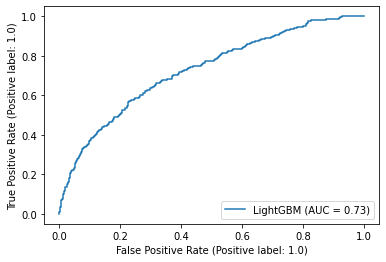

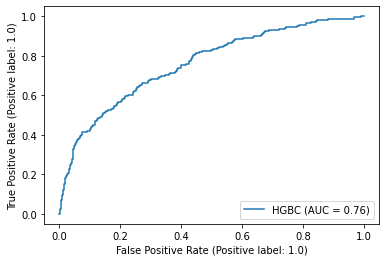

In [58]:
from sklearn.metrics import plot_roc_curve
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def runAlgos(algoName, X_train, X_test, y_train, y_test, ensemble = None):
   
    print("Starting {}.... Train shape: {}, test shape: {}".format(algoName, X_train.shape, X_test.shape))

    clf = ensemble or allModels.get(algoName) 
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print("################## Stats for {} ##########################".format(algoName))
    plot_roc_curve(clf, X_test, y_test, name = algoName)
    print(conf_matrix(y_test,y_pred))
    # calculate recall
    recall = recall_score(y_test, y_pred, average='binary')
    print('Recall: %.3f' % recall)
    from sklearn.metrics import roc_auc_score
    score = roc_auc_score(y_test, y_pred)
    print(f"ROC AUC: {score:.4f}")
    print("############################################")

    gc.collect()
    


def prepare(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
   
    with timer("Run main"):
        
        
        df.to_pickle(file_name)
        #df = df.dropna()
        print("### Picked data ###")
        #df = pd.read_pickle(file_name)
        #df = df[:1000]
        return df
    
def main():
    df = prepare(debug = True) #pd.read_pickle(file_name) #prepare(debug = False)
    
    X_train, X_test, y_train, y_test = getDatasets(df)
    # try - https://machinelearningmastery.com/voting-ensembles-with-python/
    for k in allModels.keys():

        runAlgos(k, X_train, X_test, y_train, y_test)
    ensembleModels = [(k,v) for k,v in allModels.items() ]  
    ensemble = VotingClassifier(estimators=ensembleModels, voting='hard')
    runAlgos(None, X_train, X_test, y_train, y_test, ensemble=ensemble)

#if __name__ == "__main__":
#submission_file_name = "submission_kernel02.csv"
with timer("Full model run"):
    main()